# Checagem de dados

Scripts com exemplos de como fazer o carregamento e divisão dos dados de forma estratificada.
 

In [1]:
# imports

import os
import sys
sys.path.append(os.path.abspath('..'))
from rasterio.coords import BoundingBox

import src.data.preprocess_data as data
#import src.models.unets as unets

import torch

### Definições
Quais tiles e o número de subtiels são definidos a seguir. 

In [2]:
tiles = ['032027', '032026'] 
num_subtiles = 6


Divisão do conjunto de treino, validação e teste, em que cada arquivo em data/processed dos tiles correspondentes são associados a um dos conjuntos.

É feita a estratificação baseada nas máscaras, de acordo com o valor de classe escolhida pelo usuário.

Neste exemplo, é feita pelo tipo.



In [3]:

train_files, val_files, test_files = data.train_val_test_stratify(tiles, 
                                                                  num_subtiles,
                                                                    train_size = 0.7, 
                                                                    val_size = 0.15, 
                                                                    stratify_by = 'type')



Loading:  <function yaml_filename at 0x74d3ebfae3b0>
File already saved, loading it.


In [4]:
train_files, val_files, test_files
len(train_files), len(val_files), len(test_files)

(50, 11, 11)

## Checagem de resultados da estratificação

data.check_stratification imprime o número de pixels de cada classe por divisão de conjunto. 

In [5]:
data.check_stratification(train_files+val_files+test_files, num_subtiles=6, stratify_by='type')

data.check_stratification(train_files, num_subtiles=6, stratify_by='type')
data.check_stratification(val_files, num_subtiles=6, stratify_by='type')
data.check_stratification(test_files, num_subtiles=6, stratify_by='type')
1

0 209780441 223027200; 1 592328 223027200; 2 637884 223027200; 3 170864 223027200; 4 11845683 223027200; {0: 0.9406047378974403, 1: 0.0026558554292929293, 2: 0.0028601175103305787, 3: 0.0007661128328741965, 4: 0.05311317633006198}
0 149598214 154880000; 1 290244 154880000; 2 339459 154880000; 3 34414 154880000; 4 4617669 154880000; {0: 0.9658975594008264, 1: 0.0018739927685950412, 2: 0.0021917549070247936, 3: 0.0002221978305785124, 4: 0.029814495092975207}
0 31117282 34073600; 1 148655 34073600; 2 182883 34073600; 3 50737 34073600; 4 2574043 34073600; {0: 0.9132372863448535, 1: 0.004362761786250939, 2: 0.005367293153643877, 3: 0.0014890413692712247, 4: 0.07554361734598046}
0 29064945 34073600; 1 153429 34073600; 2 115542 34073600; 3 85713 34073600; 4 4653971 34073600; {0: 0.8530048189800902, 1: 0.004502870257325319, 2: 0.0033909537002253945, 3: 0.002515525216003005, 4: 0.13658583184635611}


1

In [6]:
train_files, val_files, test_files = data.train_val_test_stratify(tiles, 
                                                                  num_subtiles,
                                                                    train_size = 0.7, 
                                                                    val_size = 0.15, 
                                                                    stratify_by = '')

Loading:  <function yaml_filename at 0x74d3ebfae3b0>
File already saved, loading it.


In [ ]:
data.check_stratification(train_files+val_files+test_files, num_subtiles=6, stratify_by='')

data.check_stratification(train_files, num_subtiles=6, stratify_by='')
data.check_stratification(val_files, num_subtiles=6, stratify_by='')
data.check_stratification(test_files, num_subtiles=6, stratify_by='')

## Salvar e carregar

Um arquivo yaml é salvo automaticamente.


In [ ]:

train_files, val_files, test_files = data.train_val_test_stratify(tiles, 
                                                                  num_subtiles,
                                                                    train_size = 0.7, 
                                                                    val_size = 0.15, 
                                                                    stratify_by = 'type')


Loading:  <function yaml_filename at 0x706243fb63b0>
File already saved, loading it.


## Dataset e dataloader

Carregamento de imagens e mascaras, por tipo.

É feita com janelamento com stride de metade do tamanho da imagem.

Adicionalmente, é feito data augmentation. As classes minoritárias que tem 1% ou mais de área da imagem geram 8 cópias contendo as transformacoes "Dihedral Group of Order 8" (ou D₄).

In [ ]:
train_dataset = data.SubtileDataset(train_files, 
                    num_subtiles = num_subtiles, 
                    classes_mode = 'type', 
                    patch_size=(256, 256), 
                    stride=128, 
                    data_augmentation = True, # testando 
                    return_imgidx = False,
                    return_nans=False,
                    debug=False)



Doing data augmentation...
Augmented 1455 images, of 9800


Das 9800 imagens, 1455 delas tiveram mais de 1% de área de classes minoritárias. Essas são readicionadas no dataset em 7 transformações adicionais.

Isso gera, para este conjunto de treino, 1455*7 + 9800 = 19985 imagens.
 

In [ ]:
len(train_dataset)


19985

### Exemplo de imagem

In [ ]:
import matplotlib.pyplot as plt

i = 0
for img, mask in train_dataset:
    if  (mask != 0).any():
        #subtile_composition.display_images(img)
        plt.figure(figsize=(20,20))
        plt.subplot(1,2,1)
        plt.imshow(mask.squeeze())
        plt.subplot(1,2,2)
        plt.imshow(img[2].squeeze(),cmap='gray')
        plt.show()
        i+=1

    if i == 3:
        pass
        break
    #img,mask = next(train_dataset)

AttributeError: 'SubtileDataset' object has no attribute 'transform'

### Dataloader

Para carregar várias imagens em batches, usamos dataloaders

In [ ]:
TODO:::
from torch.utils.data import DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, 
                            batch_size=batch_size, 
                            shuffle=True)

In [ ]:
import numpy as np

import src.data.subtile_composition as subtile_composition

In [ ]:
import matplotlib.pyplot as plt

i = 0
for img, mask in train_dataset:
    if  (mask != 0).any():
        #subtile_composition.display_images(img)
        plt.figure(figsize=(20,20))
        plt.subplot(1,2,1)
        plt.imshow(mask.squeeze())
        plt.subplot(1,2,2)
        plt.imshow(img[2].squeeze(),cmap='gray')
        plt.show()
        i+=1

    if i == 3:
        pass
        break
    #img,mask = next(train_dataset)

AttributeError: 'SubtileDataset' object has no attribute 'transform'

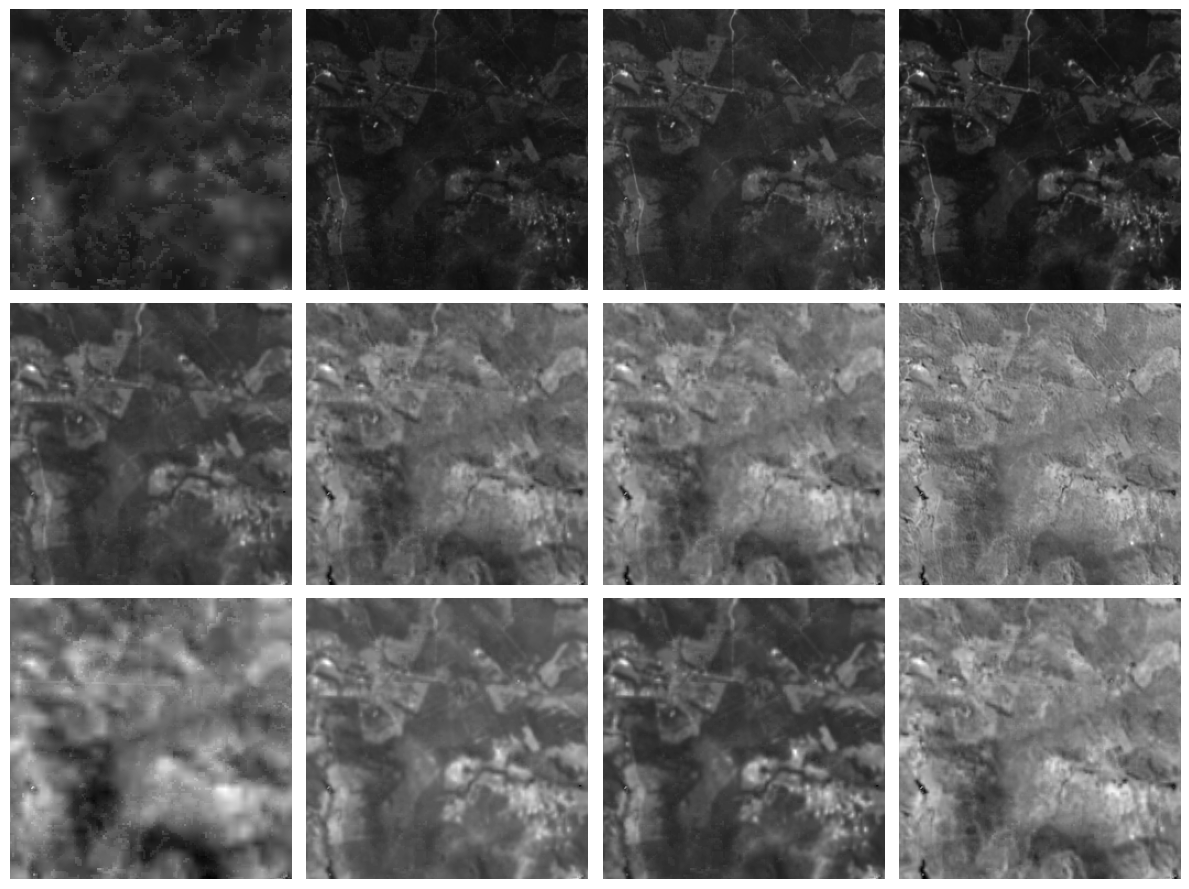

In [ ]:

subtile_composition.display_images(img)


In [ ]:

train_dataset = data.ImageDataset(files = train_files, 
                            mask_filename = "masks/raster_aurb_032027.tif", 
                            num_classes = num_classes,
                            subtile_size = 10560/6,
                            mean = mean, 
                            std = std,
                            patch_size = (patch_size, patch_size),
                            stride = stride,
                            augment = data_aug)

AttributeError: module 'src.data.preprocess_data' has no attribute 'ImageDataset'